In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
import seaborn as sns
import os
import numpy as np

In [84]:
# Define the KPIs you wish to plot
kpi_columns = [
       'mortality_rate','avg_inward_utilization', 'avg_icu_utilization', 'avg_waiting_time_ed',
       'avg_total_waiting_time', 'throughput_overall',
       'rate_target_time_mts_full', 'rejected_Patients_ED','Rate_LWBS']

titles_dataset = [
    'EDWIN Score',                        # Keep as is
    'Lab Nurse Utilization Rate',         # Match with other utilization metrics
    'Inward Utilization Rate',                 # Keep as is
    'ICU Utilization Rate',                    # Keep as is
    'Deceased Patients',                       # Match with titles
    'LWBS Count',                         # Match with titles
    'Radiologist Utilization Rate',       # Match with titles
    'ED Throughput',                # Match with titles
    'Radiology Queue Length',             # Match with titles
    'Laboratory Queue Length',            # Match with titles
    'ED Physician Utilization Rate',      # Standardize format
    'ED Queue Length',                    # Match with titles
    'Number of Rejected Patients ED',                  # Match with titles
    'Postponed Patients RAD',        # Match with titles
    'Surgeon Utilization Rate',           # Match with titles
    'Postponed Patients OR',          # Match with titles
    'Physician Queue Length',             # Match with titles
    'Lab Physician Utilization Rate',     # Match with titles
    'Nurse Utilization Rate',             # Standardize format
    'Surgery Queue Length',               # Match with titles
    'Postponed Patients LAB',       # Match with titles
    'Rate of MTS Target Time not Reached',  # Match with titles
    'X-ray Utilization Rate',         # Match with titles
    'Hospital-wide Throughput'
]

# Titles for plots
titles = [
    'Absolute Throughput of Patients Hospital-wide',
    'Absolute Throughput of Patient ED',
    'Absolute Hospital Arrivals',
    'Absolute ED Arrivals',
    'Mortality Rate',
    'Absolute Deaths',
    'LWBS Count',
    'ED Throughput',
    'ED Queue Length',
    'Radiology Queue Length',
    'Laboratory Queue Length',
    'Physician Queue Length',
    'Nursing Monitoring Queue Length',
    'Surgery Queue Length',
    'Average EDWIN Score',
    'Door-to-Doctor Time',
    'ICU Waiting Time',
    'Inward Utilization Rate',
    'ICU Utilization Rate',
    'ED Waiting Time',
    'Total Waiting Time',
    'Hospital-wide Throughput',
    'Rate of MTS Target Time not Reached',
    'Rejected Patients ED',
    'Postponed Patients RAD',
    'Postponed Patients OR',
    'Postponed Patients LAB',
    'Surgoen Utilization Rate',
    'Radiologist Utilization Rate',
    'Xray Utilization Rate',
    'Lab Doctor Utilization Rate',
    'Lab Nurse Utilization Rate',
    'Rate LWBS',
    'Adjusted Hospital-wide Throughput',
    'Adjusted Hospital-wide Throughput without Rejected'
]

# Update parameters list to remove Delay1stCountermeasure
parameters = ['Multiplier', 'RecoveryTime', 'Delay1stCountermeasure']

# Update parameter info dictionaries
param_info = {
    'Multiplier': {'symbol': 'M', 'name': 'Multiplier'},
    'NumberSteps': {'symbol': 'c', 'name': 'Number of Steps'},
    'RecoveryTime': {'symbol': 't', 'name': 'Recovery Time'}
}

param_values = {
    'Multiplier': {'minus': '2', 'plus': '4'},
    'NumberSteps': {'minus': '2', 'plus': '1'},
    'RecoveryTime': {'minus': '14', 'plus': '21'}
}

colors = {
    'Multiplier': 'blue',
    'NumberSteps': 'red',
    'RecoveryTime': 'green'
}

In [86]:
def read_specific_dataset(path, dataset_name, scenario_label):
    """
    Reads a specific dataset from the "Datasets" folder and returns it as a DataFrame.
    """
    file_path = path + f'/Datasets/{dataset_name}.csv'
    
    df = pd.read_csv(file_path, sep=",")  # Read the CSV file
    df = df.set_index(df.columns[0])  # Set the first column as the index
    df = df.reset_index(drop=True)  # Reset the index to remove the old index

    keywords = ['Utilization', 'Utiliaztion', 'Nurse', 'Utilaztion', 'Doctor']
    if any(keyword in dataset_name for keyword in keywords):
        df = df * 100
    
    # Calculate SUM and Mean before adding them as columns
    sum_values = df.sum(axis=1)
    mean_values = df.mean(axis=1)


    # Add additional columns
    df['SUM'] = sum_values
    df['Mean'] = mean_values
    df['Scenario'] = scenario_label
    df['Dataset'] = f'Dataset{dataset_name}.csv'
    return df

def recalculate_mortality_rate(df_combined, pathFiles, departments):
    for dept in departments:
        # Read specific datasets for each department
        df_overall = read_specific_dataset(pathFiles, 'DatasetOverallTroughput', dept)
        df_deceased = read_specific_dataset(pathFiles, 'DatasetDeceasedPatients', dept)


        # Calculate mortality rate
        mortality_rate = df_deceased['SUM'] * 100 / df_overall['SUM']
        # Update df_combined with new mortality rates for the specific department
        df_combined.loc[df_combined['Scenario'] == dept, 'mortality_rate'] = mortality_rate.values

        return df_combined

def calculate_ed_throughput(df_combined, pathFiles, scenarios):
    """
    Calculates the ED Throughput using the DatasetEDThroughputCorrect and updates df_combined.
    """
    for scenario in scenarios:
        # Construct the file path
        file_path = pathFiles + '/Datasets/DatasetThroughputEDCorrect.csv'
        
        # Read the specific dataset for each scenario
        df_ed_throughput = pd.read_csv(file_path, sep=",")

        
        # Set the first column as the index and reset the index
        df_ed_throughput = df_ed_throughput.set_index(df_ed_throughput.columns[0])
        df_ed_throughput = df_ed_throughput.reset_index(drop=True)
        
        # Calculate the mean ED Throughput for each day
        mean_ed_throughput = df_ed_throughput.mean(axis=1)
        
        # Update df_combined with the new ED Throughput values for the specific scenario
        df_combined.loc[df_combined['Scenario'] == scenario, 'ed_throughput_per_day'] = mean_ed_throughput.values

        return df_combined


def preprocess_data(file_path, department_label):
    df = pd.read_csv(file_path, index_col=False)

    # Check if the column ' total_num_ed_patients' exists and rename it
    if ' total_num_ed_patients' in df.columns:
        df.rename(columns={' total_num_ed_patients': 'total_num_ed_patients'}, inplace=True)

    if ' total_num_patients_entered' in df.columns:
        df.rename(columns={' total_num_patients_entered': 'total_num_patients_entered'}, inplace=True)
    
    # Calculate the rate of patients who left without being seen
    df['Rate_LWBS'] = (df['total_num_lwbs'] * 100) / df['total_num_ed_patients_entered']    
    
    # Multiply all utilization columns by 100
    utilization_columns = [col for col in df.columns if 'utilization' in col.lower()]
    for col in utilization_columns:
        df[col] = df[col] * 100

    # Round the values to 0 decimals since only full patients are possible
    for kpi in [
        'avg_queue_length_ed', 'avg_queue_length_radio', 'avg_queue_length_lab',
        'avg_queue_length_surgery', 'throughput_overall', 'ed_throughput_per_day',
        'postponed_Patients_OR', 'postponed_Patients_RAD', 'rejected_Patients_ED']:
        df[kpi] = df[kpi].round(0)
        
    df['Scenario'] = department_label
    return df


def read_effect_experiment_config():
    """
    Read the experiment configuration from Excel sheet
    """
    excel_path = '../Files/EffectAnalysis/Overview_Effect.xlsx'
    return pd.read_excel(excel_path)

def combine_experiment_data(exp_config, base_path, kpi_columns):
    """
    Combine data from all experiments into one DataFrame with parameter indicators
    """
    combined_df = pd.DataFrame()
    
    for _, row in exp_config.iterrows():
        exp_name = row['Folder']
        exp_path = os.path.join(base_path, exp_name)

        
        # Read and preprocess main KPIs
        main_kpi_path = os.path.join(exp_path, 'MainKPIs/MainKPIs.csv')
        df = preprocess_data(main_kpi_path, exp_name)

       
        # Recalculate specific metrics
        df = calculate_ed_throughput(df, exp_path, [exp_name])
        df = recalculate_mortality_rate(df, exp_path, [exp_name])
        
        # Add parameter values
        df['Multiplier'] = row['Multiplier']
        df['NumberSteps'] = row['Number of Steps']
        df['RecoveryTime'] = row['Recovery Time']
        df['Delay1stCountermeasure'] = row['Delay 1st Countermeasure']
        
        # Add parameter indicators (+/-)
        df['Multiplier_Sign'] = '+' if row['Multiplier'] == 4 else '-'
        df['NumberSteps_Sign'] = '+' if row['Number of Steps'] == 1 else '-'
        df['RecoveryTime_Sign'] = '+' if row['Recovery Time'] == 21 else '-'
        df['Delay1stCountermeasure_Sign'] = '+' if row['Delay 1st Countermeasure'] == 5 else '-'
        
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    return combined_df


def calculate_effects(df, kpi_columns):
    """Calculate main and interaction effects for parameters and KPIs"""
    parameters = ['Multiplier', 'NumberSteps', 'RecoveryTime', 'Delay1stCountermeasure']
    
    # Get all interaction column names
    interaction_columns = [col[:-5] for col in df.columns if col.endswith('_Sign') 
                         and '/' in col]
    
    # Combine main effects and interaction parameters
    all_effects = parameters + interaction_columns
    effects = pd.DataFrame(index=all_effects, columns=kpi_columns)
    
    # Calculate effects for both main parameters and interactions
    for effect in all_effects:
        for kpi in kpi_columns:
            plus_mean = df[df[f"{effect}_Sign"] == '+'][kpi].mean()
            minus_mean = df[df[f"{effect}_Sign"] == '-'][kpi].mean()
            effects.loc[effect, kpi] = plus_mean - minus_mean
    
    return effects

def add_interaction_columns(df, parameters):
    """Add interaction columns for all parameter combinations using multiplications"""
    
    # Convert +/- signs to 1/-1 for calculations
    for param in parameters:
        df[f"{param}_Value"] = np.where(df[f"{param}_Sign"] == '+', 1, -1)
    
    # Two-way interactions
    for i, param1 in enumerate(parameters):
        for param2 in parameters[i+1:]:
            col_name = f"{param1}/{param2}"
            interaction_value = df[f"{param1}_Value"] * df[f"{param2}_Value"]
            df[f"{col_name}_Sign"] = np.where(interaction_value > 0, '+', '-')
    
    # Three-way interactions
    for i, param1 in enumerate(parameters):
        for j, param2 in enumerate(parameters[i+1:], i+1):
            for param3 in parameters[j+1:]:
                col_name = f"{param1}/{param2}/{param3}"
                interaction_value = (df[f"{param1}_Value"] * 
                                  df[f"{param2}_Value"] * 
                                  df[f"{param3}_Value"])
                df[f"{col_name}_Sign"] = np.where(interaction_value > 0, '+', '-')
    
    # Four-way interaction
    col_name = "/".join(parameters)
    interaction_value = (df[f"{parameters[0]}_Value"] * 
                        df[f"{parameters[1]}_Value"] * 
                        df[f"{parameters[2]}_Value"] * 
                        df[f"{parameters[3]}_Value"])
    df[f"{col_name}_Sign"] = np.where(interaction_value > 0, '+', '-')
    
    # Clean up temporary value columns
    for param in parameters:
        df = df.drop(f"{param}_Value", axis=1)
    
    return df

def combine_experiment_data(exp_config, base_path, kpi_columns):
    """Combine data from all experiments with parameter indicators and interactions"""
    combined_df = pd.DataFrame()
    parameters = ['Multiplier', 'NumberSteps', 'RecoveryTime', 'Delay1stCountermeasure']
    
    for _, row in exp_config.iterrows():
        exp_name = row['Folder']
        exp_path = os.path.join(base_path, exp_name)
        
        # Read and preprocess main KPIs
        main_kpi_path = os.path.join(exp_path, 'MainKPIs/MainKPIs.csv')
        df = preprocess_data(main_kpi_path, exp_name)
        
        # Recalculate specific metrics
        df = calculate_ed_throughput(df, exp_path, [exp_name])
        df = recalculate_mortality_rate(df, exp_path, [exp_name])
        
        # Add parameter values
        df['Multiplier'] = row['Multiplier']
        df['NumberSteps'] = row['Number of Steps']
        df['RecoveryTime'] = row['Recovery Time']
        df['Delay1stCountermeasure'] = row['Delay 1st Countermeasure']
        
        # Add parameter indicators (+/-)
        df['Multiplier_Sign'] = '+' if row['Multiplier'] == 4 else '-'
        df['NumberSteps_Sign'] = '+' if row['Number of Steps'] == 1 else '-'
        df['RecoveryTime_Sign'] = '+' if row['Recovery Time'] == 21 else '-'
        df['Delay1stCountermeasure_Sign'] = '+' if row['Delay 1st Countermeasure'] == 5 else '-'
        
        # Add interaction columns
        df = add_interaction_columns(df, parameters)
        
        combined_df = pd.concat([combined_df, df], ignore_index=True)
    
    return combined_df


def get_kpi_labels(kpi, titles_dataset, titles):
    """Get proper title and ylabel based on KPI"""
    kpi_to_title = {
        'total_num_patients': ('Hospital-wide Throughput', 'Throughput (Patients/Day)'),
        'total_num_ed_patients': ('ED Throughput', 'Throughput (Patients/Day)'),
        'mortality_rate': ('Mortality Rate', 'Mortality Rate (\%)'),
        'total_num_lwbs': ('LWBS Count', 'Number of Patients'),
        'ed_throughput_per_day': ('ED Throughput', 'Throughput (Patients/Day)'),
        'avg_queue_length_ed': ('ED Queue Length', 'Queue Length (Patients)'),
        'avg_edwin_score': ('EDWIN Score', 'EDWIN Score'),
        'avg_waiting_time_ed': ('ED Waiting Time', 'Waiting Time (min)'),
        'Rate_LWBS': ('Rate LWBS', 'Rate LWBS (\%)'),
        'rejected_Patients_ED': ('Rejected Patients ED', 'Number of Patients'),
        'avg_inward_utilization': ('Inward Utilization Rate', 'Utilization Rate (\%)'),
        'avg_icu_utilization': ('ICU Utilization Rate', 'Utilization Rate (\%)'),
        'rate_target_time_mts_full': ('Rate of MTS Target Time not Reached', 'Rate (\%)'),
        'postponed_Patients_RAD': ('Postponed Patients RAD', 'Number of Patients'),
        'postponed_Patients_OR': ('Postponed Patients OR', 'Number of Patients'),
        'postponed_Patients_LAB': ('Postponed Patients LAB', 'Number of Patients'),
        'avg_total_waiting_time': ('Hospital-wide Waiting Time', 'Waiting Time (min)'),
        'throughput_overall': ('Hospital-wide Throughput', 'Throughput (Patients/Day)'),
        'avg_queue_length_radio': ('Radiology Queue Length', 'Queue Length (Patients)'),
        'avg_queue_length_lab': ('Laboratory Queue Length', 'Queue Length (Patients)'),
        'avg_queue_length_surgery': ('Surgery Queue Length', 'Queue Length (Patients)'),
        'avg_queue_length_mon_nurse': ('Nursing Monitoring Queue Length', 'Queue Length (Patients)'),
        'avg_waiting_time_icu': ('ICU Waiting Time', 'Waiting Time (min)'),
        'avg_door_to_doctor_time': ('Door-to-Doctor Time', 'Waiting Time (min)'),
        'avg_doctor_utilization_surgery': ('Surgeon Utilization Rate', 'Utilization Rate (\%)'),
        'avg_doctor_utilization_radio': ('Radiologist Utilization Rate', 'Utilization Rate (\%)'),
        'avg_xray_utilization': ('X-ray Utilization Rate', 'Utilization Rate (\%)'),
        'avg_doctor_utilization_lab': ('Lab Doctor Utilization Rate', 'Utilization Rate (\%)'),
        'avg_nurse_utilization_lab': ('Lab Nurse Utilization Rate', 'Utilization Rate (\%)')
        
    }
    return kpi_to_title.get(kpi, (kpi, kpi))

def plot_parameter_effects(df, kpi, parameters, titles_dataset, titles):
    """
    Plot parameter effects with LaTeX formatting and proper titles
    """
    plt.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Parameter LaTeX symbols and full names
    param_info = {
        'Multiplier': {'symbol': 'M', 'name': 'Multiplier'},
        'NumberSteps': {'symbol': 'c', 'name': 'Number of Steps'},
        'RecoveryTime': {'symbol': 't', 'name': 'Recovery Time'},
        'Delay1stCountermeasure': {'symbol': r'\Delta t', 'name': 'Delay 1st Countermeasure'}
    }
    
    # Parameter value mappings
    param_values = {
        'Multiplier': {'minus': '2', 'plus': '4'},
        'NumberSteps': {'minus': '2', 'plus': '1'},
        'RecoveryTime': {'minus': '14', 'plus': '21'},
        'Delay1stCountermeasure': {'minus': '2', 'plus': '5'}
    }
    
    colors = {
        'Multiplier': 'blue',
        'NumberSteps': 'red',
        'RecoveryTime': 'green',
        'Delay1stCountermeasure': 'orange'
    }
    
    # Calculate overall mean
    overall_mean = df[kpi].mean()
    
    # Add overall mean line
    ax.axhline(y=overall_mean, color='gray', linestyle='--', alpha=0.5,
               label=f'Overall Mean: {overall_mean:.2f}')
    
    # Create x positions for parameters
    x_positions = np.arange(len(parameters))
    width = 0.5
    
    # Plot lines for each parameter
    for i, param in enumerate(parameters):
        minus_mean = df[df[f'{param}_Sign'] == '-'][kpi].mean()
        plus_mean = df[df[f'{param}_Sign'] == '+'][kpi].mean()
        
        # Plot only the sloped line
        ax.plot([x_positions[i] - width/2, x_positions[i] + width/2],
                [minus_mean, plus_mean],
                color=colors[param],
                linewidth=2,
                label=f'(${param_info[param]["symbol"]}$) {param_info[param]["name"]}',
                marker='o',
                markersize=8,
                zorder=2)
    
    # Get proper title and ylabel
    title, ylabel = get_kpi_labels(kpi, titles_dataset, titles)
    
    # Customize plot
    ax.set_ylabel(f'{ylabel}', fontsize=12)
    ax.set_xlabel('Parameters', fontsize=12)
    ax.set_title(f'{title}', fontsize=14, pad=20)
    
    # Set x-ticks for parameters and their actual values
    all_ticks = []
    all_labels = []
    for i, param in enumerate(parameters):
        all_ticks.extend([x_positions[i] - width/2, x_positions[i], x_positions[i] + width/2])
        all_labels.extend([
            param_values[param]['minus'],
            f'${param_info[param]["symbol"]}$',
            param_values[param]['plus']
        ])
    
    ax.set_xticks(all_ticks)
    ax.set_xticklabels(all_labels)
    
    # Add grid
    #ax.grid(True, linestyle='--', alpha=0.7)
    
    # Customize legend
    ax.legend(title='Parameters',
             bbox_to_anchor=(1.05, 1),
             loc='upper left',
             borderaxespad=0.)
    
    plt.tight_layout()
    plt.savefig(f'Effect_plots/{kpi}_effects.pdf',
                format='pdf',
                bbox_inches='tight',
                dpi=300)
    plt.show()


def format_effect_output(df, effects, kpi, parameters):
    """
    Format the effect analysis output in a structured way, with systematic experiment ordering
    """
    # Map parameters to letters
    param_letters = {
        'Multiplier': 'A',
        'NumberSteps': 'B',
        'RecoveryTime': 'C',
        'Delay1stCountermeasure': 'D'
    }
    
    print(f"\nKPI: {kpi}")
    print("=" * 80)
    
    # Header
    header = "Exp  "
    for param in parameters:
        header += f"{param_letters[param]}  "
    header += "Value"
    print(header)
    print("-" * 80)
    
    # Create all possible combinations of +/- in systematic order
    combinations = []
    for i in range(16):  # 2^4 = 16 combinations
        combo = []
        for j in range(4):  # 4 parameters
            # Convert binary representation to +/-
            combo.append('+' if (i & (1 << j)) else '-')
        combinations.append(combo)
    
    # Print each experiment configuration in systematic order
    for exp_num, combo in enumerate(combinations, 1):
        # Find matching data
        mask = True
        for param, sign in zip(parameters, combo):
            mask = mask & (df[f"{param}_Sign"] == sign)
        
        if mask.any():
            line = f"{exp_num:<5}"
            for sign in combo:
                line += f"{sign:<3}"
            line += f"{df[mask][kpi].mean():>8.2f}"
            print(line)
    
    print("-" * 80)

    # Add overall mean after the experiment list
    overall_mean = df[kpi].mean()
    print(f"\nOverall Mean: {overall_mean:>8.2f}")
    
    # Rest of the function remains the same...
    # Print main effects for each parameter
    print("\nMain Effects:")
    for param in parameters:
        plus_mean = df[df[f"{param}_Sign"] == '+'][kpi].mean()
        minus_mean = df[df[f"{param}_Sign"] == '-'][kpi].mean()
        effect = effects.loc[param, kpi]
        
        print(f"{param_letters[param]}:")
        print(f"Mean (+): {plus_mean:>8.2f}")
        print(f"Mean (-): {minus_mean:>8.2f}")
        print(f"Effect:   {effect:>8.2f}")
        print("-" * 40)
    
    # Print two-way interactions
    print("\nTwo-way Interactions:")
    for i, param1 in enumerate(parameters):
        for param2 in parameters[i+1:]:
            interact_key = f"{param1}/{param2}"
            if interact_key in effects.index:
                effect = effects.loc[interact_key, kpi]
                print(f"{param_letters[param1]}{param_letters[param2]}:    {effect:>8.2f}")
    
    # Print three-way interactions
    print("\nThree-way Interactions:")
    for i, param1 in enumerate(parameters):
        for j, param2 in enumerate(parameters[i+1:], i+1):
            for param3 in parameters[j+1:]:
                interact_key = f"{param1}/{param2}/{param3}"
                if interact_key in effects.index:
                    effect = effects.loc[interact_key, kpi]
                    print(f"{param_letters[param1]}{param_letters[param2]}{param_letters[param3]}:     {effect:>8.2f}")
    
    # Print four-way interaction
    four_way_key = "/".join(parameters)
    if four_way_key in effects.index:
        print("\nFour-way Interaction:")
        effect = effects.loc[four_way_key, kpi]
        print(f"ABCD:    {effect:>8.2f}")

def calculate_single_factor_effects(df, kpi, parameters):
    """
    Calculate effects for single factorial design
    Base configuration: All parameters at low value (2,14,2)
    """
    effects = {}
    base_config = {
        'Multiplier': 2,
        'RecoveryTime': 14,
        'Delay1stCountermeasure': 2
    }
    
    # Get base configuration value (Exp1: all parameters low)
    base_mask = True
    for param, value in base_config.items():
        base_mask &= (df[param] == value)
    base_value = df[base_mask][kpi].mean()
    
    # Calculate effect for each parameter
    for param in parameters:
        # Create high configuration (only current parameter high, others low)
        high_config = base_config.copy()
        high_config[param] = {
            'Multiplier': 4,
            'RecoveryTime': 21,
            'Delay1stCountermeasure': 5
        }[param]
        
        # Get high configuration value
        high_mask = True
        for p, v in high_config.items():
            high_mask &= (df[p] == v)
        high_value = df[high_mask][kpi].mean()
        
        # Store values and effect
        effects[param] = {
            'low_value': base_value,
            'high_value': high_value,
            'effect': high_value - base_value
        }
    
    return effects


def plot_single_factor_effects(df, kpi, parameters, titles_dataset, titles, ax=None):
    """
    Plot single factor effects with LaTeX formatting and improved visuals
    Args:
        df: DataFrame with the data
        kpi: KPI to analyze
        parameters: List of parameters to plot
        titles_dataset: Dataset titles
        titles: Plot titles
        ax: Matplotlib axis object (optional)
    """
    plt.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })
    
    # Create axis if not provided
    if ax is None:
        _, ax = plt.subplots(figsize=(8, 4))
    
    effects = calculate_single_factor_effects(df, kpi, parameters)
    
    param_info = {
        'Multiplier': {'symbol': 'M', 'name': 'Multiplier'},
        'RecoveryTime': {'symbol': 't', 'name': 'Recovery Time'},
        'Delay1stCountermeasure': {'symbol': r'\Delta t', 'name': 'Delay 1st Countermeasure'}
    }
    
    param_values = {
        'Multiplier': {'minus': '2', 'plus': '4'},
        'RecoveryTime': {'minus': '14', 'plus': '21'},
        'Delay1stCountermeasure': {'minus': '2', 'plus': '5'}
    }
    
    colors = {
        'Multiplier': 'blue',
        'RecoveryTime': 'green',
        'Delay1stCountermeasure': 'orange'
    }
    
    x_positions = np.arange(len(parameters))
    width = 0.5
    
    # Plot lines for each parameter
    y_values = []
    for i, param in enumerate(parameters):
        y_values.extend([effects[param]['low_value'], effects[param]['high_value']])
        
        ax.plot([x_positions[i] - width/2, x_positions[i] + width/2],
                [effects[param]['low_value'], effects[param]['high_value']],
                color=colors[param],
                linewidth=2,
                label=f'(${param_info[param]["symbol"]}$) {param_info[param]["name"]}',
                marker='o',
                markersize=8,
                zorder=2)
    
    # Set y-axis limits
    y_min, y_max = min(y_values), max(y_values)
    margin = (y_max - y_min) * 0.1
    ax.set_ylim(y_min - margin, y_max + margin)
    
    # Get and set labels
    title, ylabel = get_kpi_labels(kpi, titles_dataset, titles)
    ax.set_ylabel(f'{ylabel}', fontsize=10)
    ax.set_xlabel('Recovery Parameters', fontsize=10)
    ax.set_title(f'{title}', fontsize=12, pad=10)
    
    # Set x-ticks
    all_ticks = []
    all_labels = []
    for i, param in enumerate(parameters):
        all_ticks.extend([x_positions[i] - width/2, x_positions[i], x_positions[i] + width/2])
        all_labels.extend([
            param_values[param]['minus'],
            f'${param_info[param]["symbol"]}$',
            param_values[param]['plus']
        ])
    
    ax.set_xticks(all_ticks)
    ax.set_xticklabels(all_labels, fontsize=8)
    
    # Add legend with smaller font
    ax.legend(title='Parameters', fontsize=8, title_fontsize=9, 
             bbox_to_anchor=(1.05, 1), loc='upper left')
    
    return ax


def plot_interaction_effects(df, kpi, parameters):
    """
    Plot two-way interaction effects for all parameter combinations
    """
    param_letters = {
        'Multiplier': 'A',
        'NumberSteps': 'B',
        'RecoveryTime': 'C',
        'Delay1stCountermeasure': 'D'
    }
    
    # Create subplots for each interaction combination
    n_interactions = (len(parameters) * (len(parameters) - 1)) // 2
    n_rows = (n_interactions + 1) // 2  # 2 plots per row
    fig, axes = plt.subplots(n_rows, 2, figsize=(15, 5*n_rows))
    axes = axes.flatten()
    
    interaction_idx = 0
    for i, param1 in enumerate(parameters):
        for param2 in parameters[i+1:]:
            ax = axes[interaction_idx]
            
            # Plot lines for param2's + and - values
            for sign2 in ['+', '-']:
                # Get data for param1's - and + values where param2 is fixed
                mask_minus = (df[f'{param1}_Sign'] == '-') & (df[f'{param2}_Sign'] == sign2)
                mask_plus = (df[f'{param1}_Sign'] == '+') & (df[f'{param2}_Sign'] == sign2)
                
                y_minus = df[mask_minus][kpi].mean()
                y_plus = df[mask_plus][kpi].mean()
                
                # Plot interaction line
                ax.plot([-0.5, 0.5], [y_minus, y_plus], 
                       marker='o',
                       label=f'{param_letters[param2]} = {sign2}',
                       linewidth=2,
                       markersize=8)
            
            # Customize subplot
            ax.set_xticks([-0.5, 0.5])
            ax.set_xticklabels(['-', '+'])
            ax.set_xlabel(f'{param_letters[param1]}')
            ax.set_title(f'Interaction {param_letters[param1]}{param_letters[param2]}')
            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend()
            
            # Add overall mean line
            overall_mean = df[kpi].mean()
            ax.axhline(y=overall_mean, color='gray', linestyle='--', alpha=0.5,
                      label='Overall Mean')
            
            interaction_idx += 1
    
    # Remove empty subplots if any
    for idx in range(interaction_idx, len(axes)):
        fig.delaxes(axes[idx])
    
    # Add common ylabel and title
    fig.text(0.04, 0.5, kpi, va='center', rotation='vertical', fontsize=12)
    fig.suptitle(f'Interaction Effects: {kpi}', fontsize=14, y=1.02)
    
    plt.tight_layout()
    plt.savefig(f'Effect_plots/{kpi}_interactions.pdf', 
                format='pdf',
                bbox_inches='tight',
                dpi=300)
    plt.show()


    
# # Main execution
# base_path = '../Files/EffectAnalysis/'
# parameters = ['Multiplier', 'NumberSteps', 'RecoveryTime', 'Delay1stCountermeasure']

# # Read experiment configuration
# exp_config = read_effect_experiment_config()

# # Combine all experiment data
# combined_df = combine_experiment_data(exp_config, base_path, kpi_columns)

# for kpi in kpi_columns:
#     # Calculate effects
#     effects = calculate_effects(combined_df, [kpi])
    
#     # Format and display results
#     format_effect_output(combined_df, effects, kpi, parameters)
    
#     # Create plot
#     plot_parameter_effects(combined_df, kpi, parameters, titles_dataset, titles)
#     #plot_interaction_effects(combined_df, kpi, parameters)
#     #plot_higher_order_interactions(combined_df, kpi, parameters)

In [107]:
# Main execution
base_path = '../Files/EffectAnalysis/'
parameters = ['Multiplier', 'RecoveryTime', 'Delay1stCountermeasure']

# Read experiment configuration
exp_config = read_effect_experiment_config()

# Combine all experiment data for base analysis
combined_df = combine_experiment_data(exp_config, base_path, kpi_columns)

# For each KPI, calculate and plot single factor effects
for kpi in kpi_columns:
    # Calculate and plot single factor effects
    #plot_single_factor_effects(combined_df, kpi, parameters, titles_dataset, titles)
    
    # Print effects table for documentation
    effects = calculate_single_factor_effects(combined_df, kpi, parameters)
    print(f"\nSingle Factor Effects for {kpi}:")
    print("=" * 80)
    print(f"{'Parameter':<20} {'Base':<10} {'High':<10} {'Effect':<10}")
    print("-" * 80)
    for param, values in effects.items():
        print(f"{param:<20} {values['low_value']:>10.2f} {values['high_value']:>10.2f} {values['effect']:>10.2f}")
    print("\n")


Single Factor Effects for mortality_rate:
Parameter            Base       High       Effect    
--------------------------------------------------------------------------------
Multiplier                 0.98       1.02       0.03
RecoveryTime               0.98       0.90      -0.08
Delay1stCountermeasure       0.98       1.00       0.02



Single Factor Effects for avg_inward_utilization:
Parameter            Base       High       Effect    
--------------------------------------------------------------------------------
Multiplier                64.49      63.34      -1.15
RecoveryTime              64.49      63.41      -1.08
Delay1stCountermeasure      64.49      64.01      -0.48



Single Factor Effects for avg_icu_utilization:
Parameter            Base       High       Effect    
--------------------------------------------------------------------------------
Multiplier                56.83      56.13      -0.71
RecoveryTime              56.83      56.25      -0.59
Delay1stCount

In [82]:
def create_multi_panel_figure(df, kpi_list, parameters, titles_dataset, titles):
    """
    Create a multi-panel figure for single factor effects analysis suitable for DIN A4 format.
    """
    plt.rcParams.update({
        "pgf.texsystem": "pdflatex",
        'font.family': 'serif',
        'text.usetex': True,
        'pgf.rcfonts': False,
    })
    
    # Create a figure with DIN A4 proportions
    fig, axes = plt.subplots(len(kpi_list), 1, figsize=(8.27, 11.69))  # A4 size in inches (width, height)
    
    for idx, kpi in enumerate(kpi_list):
        ax = axes[idx]
        effects = calculate_single_factor_effects(df, kpi, parameters)
        
        param_info = {
            'Multiplier': {'symbol': 'M', 'name': 'Multiplier'},
            'RecoveryTime': {'symbol': 't', 'name': 'Recovery Time'},
            'Delay1stCountermeasure': {'symbol': r'\Delta t', 'name': 'Delay 1st Countermeasure'}
        }
        
        param_values = {
            'Multiplier': {'minus': '2', 'plus': '4'},
            'RecoveryTime': {'minus': '14', 'plus': '21'},
            'Delay1stCountermeasure': {'minus': '2', 'plus': '5'}
        }
        
        colors = {
            'Multiplier': 'blue',
            'RecoveryTime': 'green',
            'Delay1stCountermeasure': 'orange'
        }
        
        x_positions = np.arange(len(parameters))
        width = 0.5
        
        # Collect y values and plot lines
        y_values = []
        for i, param in enumerate(parameters):
            y_values.extend([effects[param]['low_value'], effects[param]['high_value']])
            
            ax.plot([x_positions[i] - width/2, x_positions[i] + width/2],
                    [effects[param]['low_value'], effects[param]['high_value']],
                    color=colors[param],
                    linewidth=2,
                    label=f'(${param_info[param]["symbol"]}$) {param_info[param]["name"]}',
                    marker='o',
                    markersize=8,
                    zorder=2)
        
        # Set y-axis limits and add reference lines
        y_min, y_max = min(y_values), max(y_values)
        margin = (y_max - y_min) * 0.1
        ax.set_ylim(y_min - margin, y_max + margin)
        
        y_ticks = ax.get_yticks()
        y_range = y_max - y_min
        min_gap = y_range * 0.05
        
        for y_tick in y_ticks:
            if (y_tick > y_min + min_gap and y_tick < y_max - min_gap):
                ax.axhline(y=y_tick, color='gray', linestyle=':', alpha=0.3, zorder=1)
        
        # Get and set labels
        title, ylabel = get_kpi_labels(kpi, titles_dataset, titles)
        ax.set_ylabel(f'{ylabel}', fontsize=12)
        ax.set_xlabel('Recovery Parameters', fontsize=12)
        ax.set_title(f'{title}', fontsize=14, pad=20)
        
        # Set x-ticks
        all_ticks = []
        all_labels = []
        for i, param in enumerate(parameters):
            all_ticks.extend([x_positions[i] - width/2, x_positions[i], x_positions[i] + width/2])
            all_labels.extend([
                param_values[param]['minus'],
                f'${param_info[param]["symbol"]}$',
                param_values[param]['plus']
            ])
        
        ax.set_xticks(all_ticks)
        ax.set_xticklabels(all_labels)
        
        ax.legend(title='Recovery Parameters')
    
    plt.tight_layout()
    plt.savefig('Effect_plots/multi_panel_single_factor_effects.pdf',
                format='pdf',
                bbox_inches='tight',
                dpi=300)
    plt.show()

In [88]:
def plot_single_factor_effects(df, kpi, parameters, titles_dataset, titles, ax=None, show_legend=True):
    """
    Plot single factor effects with LaTeX formatting and improved visuals
    """
    effects = calculate_single_factor_effects(df, kpi, parameters)
    
    param_info = {
        'Multiplier': {'symbol': 'M', 'name': 'Multiplier'},
        'RecoveryTime': {'symbol': 't', 'name': 'Recovery Time'},
        'Delay1stCountermeasure': {'symbol': r'\Delta t', 'name': 'Delay 1st Countermeasure'}
    }
    
    param_values = {
        'Multiplier': {'minus': '2', 'plus': '4'},
        'RecoveryTime': {'minus': '14', 'plus': '21'},
        'Delay1stCountermeasure': {'minus': '2', 'plus': '5'}
    }
    
    colors = {
        'Multiplier': 'blue',
        'RecoveryTime': 'green',
        'Delay1stCountermeasure': 'orange'
    }
    
    x_positions = np.arange(len(parameters))
    width = 0.5
    
    # Collect y values and plot lines
    y_values = []
    handles = []
    
    for i, param in enumerate(parameters):
        y_values.extend([effects[param]['low_value'], effects[param]['high_value']])
        
        line = ax.plot([x_positions[i] - width/2, x_positions[i] + width/2],
                      [effects[param]['low_value'], effects[param]['high_value']],
                      color=colors[param],
                      linewidth=2,
                      label=f'(${param_info[param]["symbol"]}$) {param_info[param]["name"]}',
                      marker='o',
                      markersize=8,
                      zorder=3)
        handles.append(line[0])
    
    # Set y-axis limits and add reference lines
    y_min, y_max = min(y_values), max(y_values)
    margin = (y_max - y_min) * 0.1
    ax.set_ylim(y_min - margin, y_max + margin)
    
    # Add horizontal dotted lines for orientation
    y_ticks = ax.get_yticks()
    for y_tick in y_ticks:
        if y_tick > y_min and y_tick < y_max:
            ax.axhline(y=y_tick, color='gray', linestyle=':', alpha=0.3, zorder=1)
    
    # Get and set labels
    title, ylabel = get_kpi_labels(kpi, titles_dataset, titles)
    ax.set_ylabel(f'{ylabel}', fontsize=10)
    ax.set_xlabel('Recovery Parameters', fontsize=10)
    ax.set_title(f'{title}', fontsize=12, pad=10)
    
    # Set x-ticks
    all_ticks = []
    all_labels = []
    for i, param in enumerate(parameters):
        all_ticks.extend([x_positions[i] - width/2, x_positions[i], x_positions[i] + width/2])
        all_labels.extend([
            param_values[param]['minus'],
            f'${param_info[param]["symbol"]}$',
            param_values[param]['plus']
        ])
    
    ax.set_xticks(all_ticks)
    ax.set_xticklabels(all_labels, fontsize=8)
    
    # Add legend only if requested
    if show_legend:
        ax.legend(title='Parameters', fontsize=8, title_fontsize=9)
    
    return handles

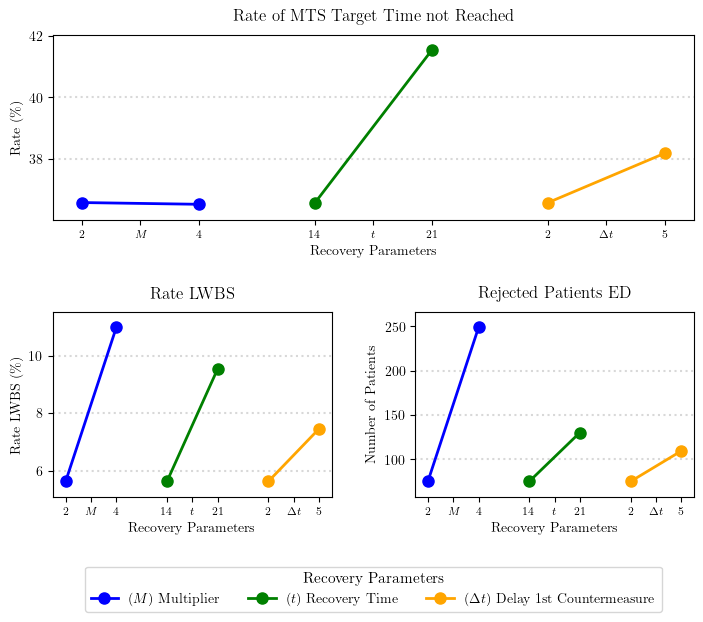

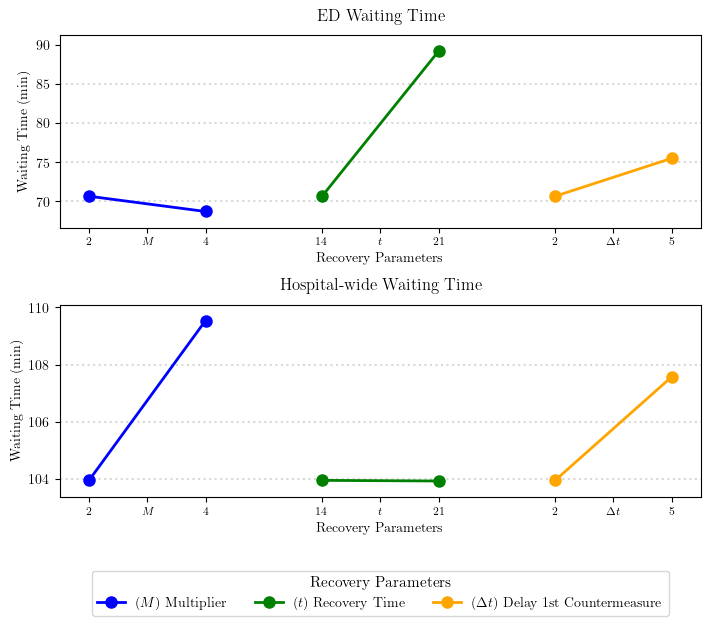

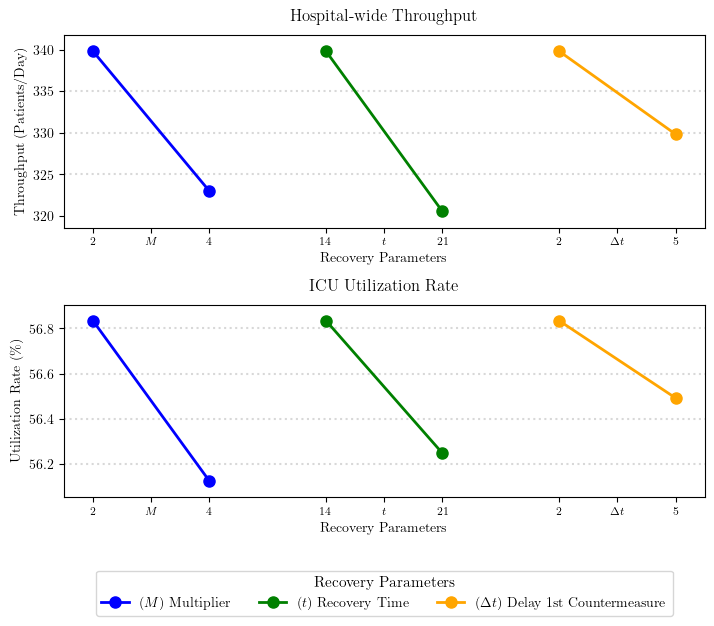

In [106]:
# Main execution
base_path = '../Files/EffectAnalysis/'
parameters = ['Multiplier', 'RecoveryTime', 'Delay1stCountermeasure']

# Read experiment configuration
exp_config = read_effect_experiment_config()
combined_df = combine_experiment_data(exp_config, base_path, kpi_columns)

# Figure 1: Rate LWBS, Rejected Patients, and MTS Target Time
fig1 = plt.figure(figsize=(8.27, 6))
gs1 = fig1.add_gridspec(2, 2, height_ratios=[1, 1], hspace=0.5, wspace=0.3)

# Bottom row: MTS Target Time (spanning both columns)
ax3 = fig1.add_subplot(gs1[0, :])
# Top row: Rate LWBS and Rejected Patients
ax1 = fig1.add_subplot(gs1[1, 0])
ax2 = fig1.add_subplot(gs1[1, 1])


handles1 = plot_single_factor_effects(combined_df, 'Rate_LWBS', parameters, titles_dataset, titles, ax=ax1, show_legend=False)
plot_single_factor_effects(combined_df, 'rejected_Patients_ED', parameters, titles_dataset, titles, ax=ax2, show_legend=False)
plot_single_factor_effects(combined_df, 'rate_target_time_mts_full', parameters, titles_dataset, titles, ax=ax3, show_legend=False)

# Add legend at the bottom
legend_ax = fig1.add_subplot(gs1[-1, :])
legend_ax.axis('off')
legend_ax.legend(handles=handles1, ncol=3, loc='center', bbox_to_anchor=(0.5, -0.5),
                title='Recovery Parameters', fontsize=10, title_fontsize=11)

plt.savefig('Effect_plots/emergency_metrics.pdf', format='pdf', bbox_inches='tight', dpi=300)

# Figure 2: ED Waiting Time and Hospital-Wide
fig2 = plt.figure(figsize=(8.27, 6))
gs2 = fig2.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.4)

ax4 = fig2.add_subplot(gs2[0])
ax5 = fig2.add_subplot(gs2[1])

handles2 = plot_single_factor_effects(combined_df, 'avg_waiting_time_ed', parameters, titles_dataset, titles, ax=ax4, show_legend=False)
plot_single_factor_effects(combined_df, 'avg_total_waiting_time', parameters, titles_dataset, titles, ax=ax5, show_legend=False)

# Add legend at the bottom
legend_ax = fig2.add_subplot(gs2[-1])
legend_ax.axis('off')
legend_ax.legend(handles=handles2, ncol=3, loc='center', bbox_to_anchor=(0.5, -0.5),
                title='Recovery Parameters', fontsize=10, title_fontsize=11)

plt.savefig('Effect_plots/waiting_times.pdf', format='pdf', bbox_inches='tight', dpi=300)

# Figure 3: Hospital-Wide Throughput and ICU Utilization
fig3 = plt.figure(figsize=(8.27, 6))
gs3 = fig3.add_gridspec(2, 1, height_ratios=[1, 1], hspace=0.4)

ax6 = fig3.add_subplot(gs3[0])
ax7 = fig3.add_subplot(gs3[1])

handles3 = plot_single_factor_effects(combined_df, 'throughput_overall', parameters, titles_dataset, titles, ax=ax6, show_legend=False)
plot_single_factor_effects(combined_df, 'avg_icu_utilization', parameters, titles_dataset, titles, ax=ax7, show_legend=False)

# Add legend at the bottom
legend_ax = fig3.add_subplot(gs3[-1])
legend_ax.axis('off')
legend_ax.legend(handles=handles3, ncol=3, loc='center', bbox_to_anchor=(0.5, -0.5),
                title='Recovery Parameters', fontsize=10, title_fontsize=11)

plt.savefig('Effect_plots/throughput_utilization.pdf', format='pdf', bbox_inches='tight', dpi=300)

plt.show()